In [70]:
!pip install requests PyPDF2 pandas numpy matplotlib seaborn nltk scikit-learn gensim


In [71]:
import requests
from PyPDF2 import PdfReader

import PyPDF2
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
#nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import pos_tag
from nltk import RegexpParser
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mados\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mados\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mados\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mados\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
#download both pdfs from source and read them

url1 = 'https://www.berkshirehathaway.com/letters/2007ltr.pdf'
url2 = 'https://www.berkshirehathaway.com/letters/2009ltr.pdf'

#download pdfs
r1 = requests.get(url1, allow_redirects=True)
r2 = requests.get(url2, allow_redirects=True)

#write pdfs to file
open('2007ltr.pdf', 'wb').write(r1.content)
open('2009ltr.pdf', 'wb').write(r2.content)

#read pdfs
pdf1 = PdfReader('2007ltr.pdf')
pdf2 = PdfReader('2009ltr.pdf')


In [73]:
#Clean the texts  Tokenize  Explore  Feature Engineer (for example Lemmatize / Stemming / POS / n-grams (one or combination)  Vectorize  Compare

#clean the text

#Extract words as strings from pdf 
def extract_words(pdf):
    text = ''
    for page in pdf.pages:
        text += page.extract_text()
    return text

text1 = extract_words(pdf1)
text2 = extract_words(pdf2)

#lowercase 
text1 = text1.lower()
text2 = text2.lower()

#remove punctuation
text1 = re.sub(r'[^\w\s.,!?;-]', '', text1)
text2 = re.sub(r'[^\w\s.,!?;-]', '', text2)

#remove /n 
text1 = text1.replace('\n', ' ')
text2 = text2.replace('\n', ' ')

#remove nonwords 
text1 = re.sub(r'\d+', '', text1)
text2 = re.sub(r'\d+', '', text2)

# Remove Tabs (".........")
regex_pattern = r'\.{4,}'
text1 = re.sub(regex_pattern, '', text1)
text2 = re.sub(regex_pattern, '', text2)



In [74]:
#Text summarization 

#2007
sentences1 = sent_tokenize(text1)
sentences1 = [sentence for sentence in sentences1 if len(sentence) > 20]
sentences1_head = sentences1[:10]

#2009
sentences2 = sent_tokenize(text2)
sentences2 = [sentence for sentence in sentences2 if len(sentence) > 20]
sentences2_head = sentences2[:10]

print('2007: ', sentences1_head)
print('2009: ', sentences2_head)

2007:  ['note the following table appears in the printed annual report on the facing page of the chairmans letter  and is referred to in that letter.', 'berkshires corporate performance vs. the sp      annual percentage change     in per-share in sp      book value of with dividends relative    berkshire included results  year       -     .', 'compounded annual gain  - .', 'overall gain  - , ,   notes data are for calendar years with these exceptions   and , year ended ; ,  months ended .', 'starting in , accounting rules required insurance companie s to value the equity securities they hold at market  rather than at the lower of cost or market, which was prev iously the requirement.', 'in this table, berkshires results  through  have been restated to conform to the changed rule s.  in all other respects, the results are calculated using  the numbers originally reported.', 'the sp  numbers are pre-tax  whereas the berkshire numbers are after-tax .', 'if a corporation such as berkshire 

In [75]:
print('2007: ', len(sentences1))
print('2009: ', len(sentences2))


2007:  652
2009:  550


In [76]:
# remove punctuation after sentence tokenization
text1 = re.sub(r'[^\w\s]', '', text1)
text2 = re.sub(r'[^\w\s]', '', text2)

In [77]:
#tokenize 
tokens1 = word_tokenize(text1)
tokens2 = word_tokenize(text2)

#remove stopwords
stop_words = set(stopwords.words('english'))
tokens1 = [word for word in tokens1 if word not in stop_words]
tokens2 = [word for word in tokens2 if word not in stop_words]


#explore
print('2007: ', len(tokens1))
print('2009: ', len(tokens2))

2007:  6306
2009:  5649


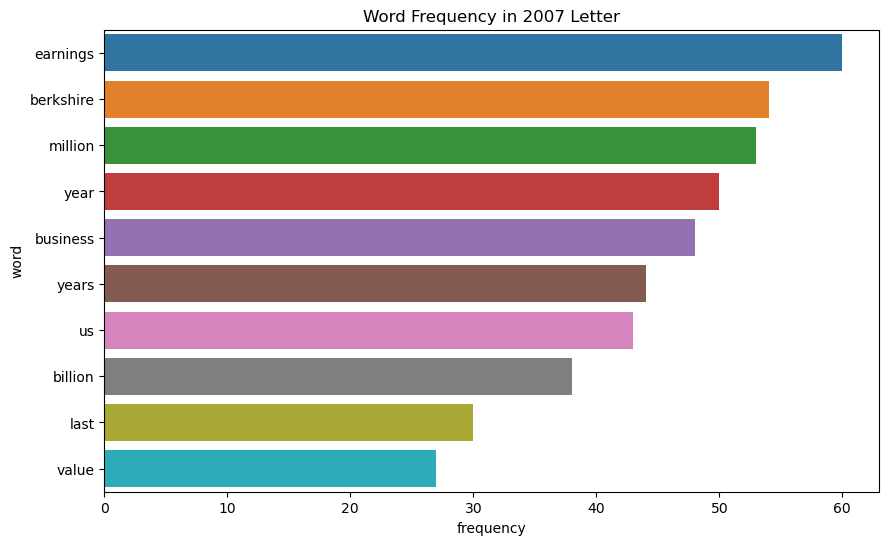

Text(0.5, 1.0, 'Word Frequency in 2009 Letter')

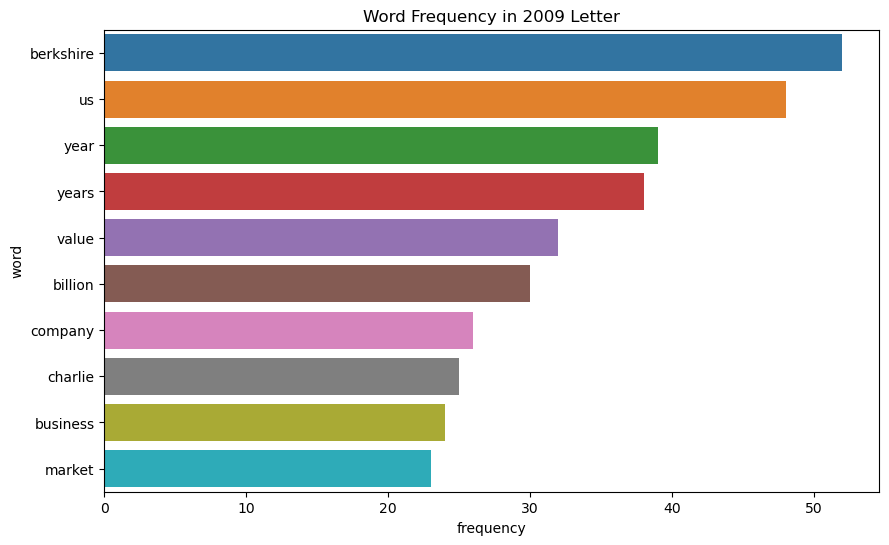

In [78]:
# text summarization by visuals
from collections import Counter
word_freq1 = Counter(tokens1)
word_freq2 = Counter(tokens2)

df1 = pd.DataFrame(word_freq1.items(), columns=['word', 'frequency'])
df2 = pd.DataFrame(word_freq2.items(), columns=['word', 'frequency'])

df1 = df1.sort_values(by='frequency', ascending=False)
df2 = df2.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=df1.head(10))
plt.title('Word Frequency in 2007 Letter')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=df2.head(10))
plt.title('Word Frequency in 2009 Letter')

In [79]:
#Feature Engineer A (Lemmitize) 
lemmatizer = WordNetLemmatizer()
lemmatized1 = [lemmatizer.lemmatize(token) for token in tokens1]
lemmatized2 = [lemmatizer.lemmatize(token) for token in tokens2]

print('2007: ', lemmatized1[:10])
print('2009: ', lemmatized2[:10])


2007:  ['note', 'following', 'table', 'appears', 'printed', 'annual', 'report', 'facing', 'page', 'chairman']
2009:  ['berkshire', 'corporate', 'performance', 'v', 'sp', 'annual', 'percentage', 'change', 'yearin', 'pershare']


In [80]:
#Feature Engineer B (POS tagging) 
pos1 = pos_tag(tokens1)
pos2 = pos_tag(tokens2)

print('2007: ', pos1[:5])
print('2009: ', pos2[:5])

2007:  [('note', 'NN'), ('following', 'VBG'), ('table', 'JJ'), ('appears', 'VBZ'), ('printed', 'JJ')]
2009:  [('berkshires', 'NNS'), ('corporate', 'JJ'), ('performance', 'NN'), ('vs', 'NN'), ('sp', 'JJ')]


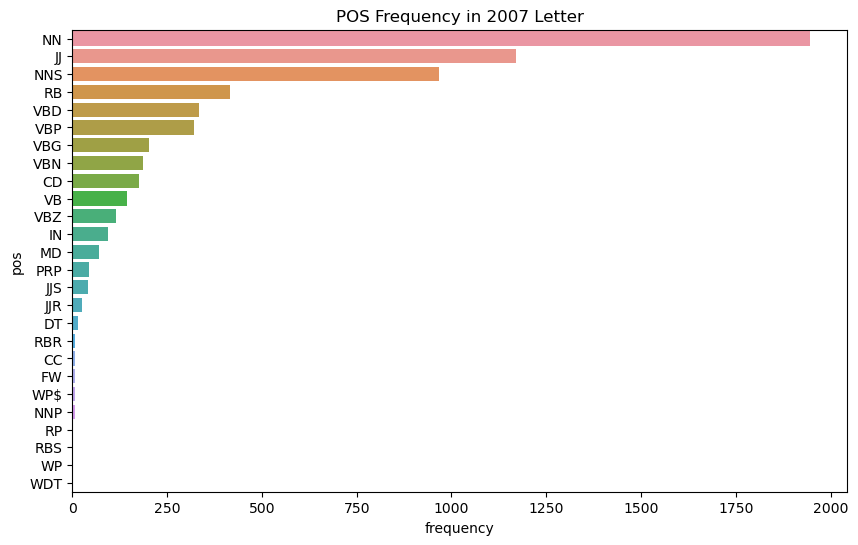

Text(0.5, 1.0, 'POS Frequency in 2009 Letter')

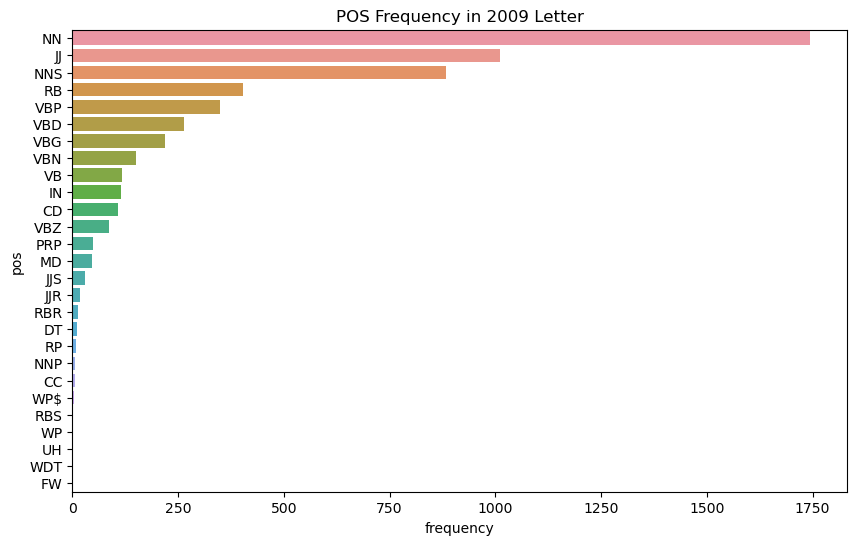

In [81]:
# Find the most common POS
pos_freq1 = Counter([pos for word, pos in pos1])
pos_freq2 = Counter([pos for word, pos in pos2])

df_pos1 = pd.DataFrame(pos_freq1.items(), columns=['pos', 'frequency'])
df_pos2 = pd.DataFrame(pos_freq2.items(), columns=['pos', 'frequency'])

df_pos1 = df_pos1.sort_values(by='frequency', ascending=False)
df_pos2 = df_pos2.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='pos', data=df_pos1)
plt.title('POS Frequency in 2007 Letter')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='pos', data=df_pos2)
plt.title('POS Frequency in 2009 Letter')

In [82]:
#Feature Engineer C (n-grams)
bigrams1 = list(ngrams(tokens1, 2))
bigrams2 = list(ngrams(tokens2, 2))

print('2007: ', bigrams1[:5])
print('2009: ', bigrams2[:5])

2007:  [('note', 'following'), ('following', 'table'), ('table', 'appears'), ('appears', 'printed'), ('printed', 'annual')]
2009:  [('berkshires', 'corporate'), ('corporate', 'performance'), ('performance', 'vs'), ('vs', 'sp'), ('sp', 'annual')]


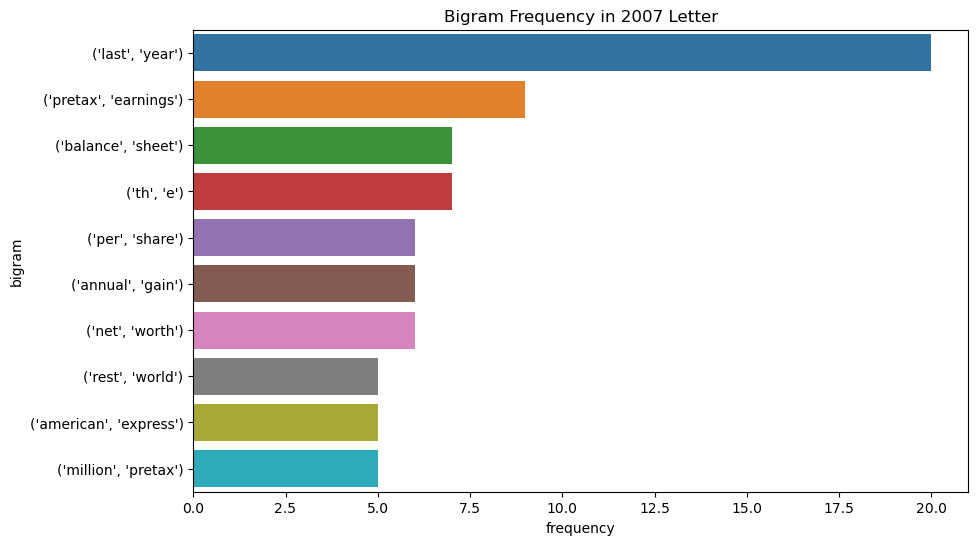

Text(0.5, 1.0, 'Bigram Frequency in 2009 Letter')

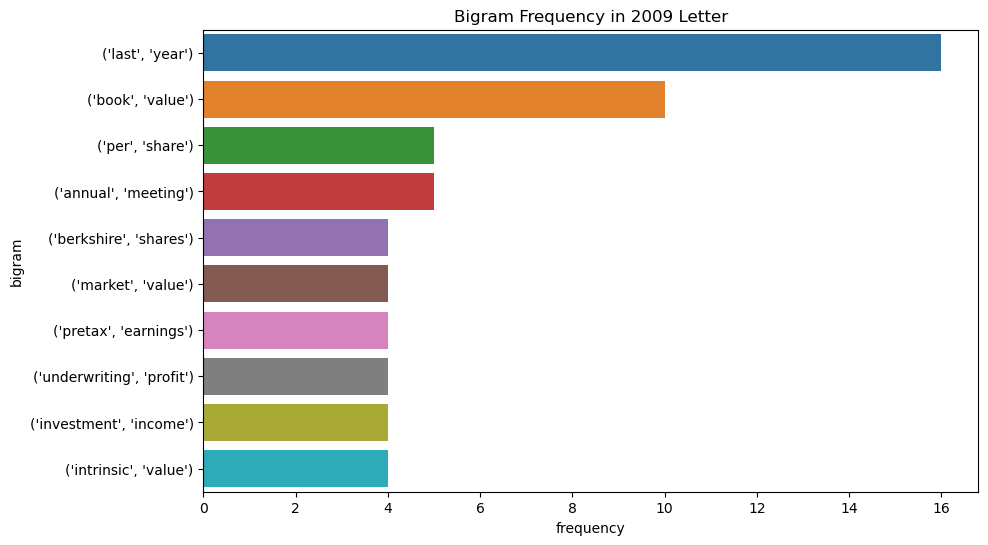

In [83]:
# find the most common bigrams
bigram_freq1 = Counter(bigrams1)
bigram_freq2 = Counter(bigrams2)

df_bigram1 = pd.DataFrame(bigram_freq1.items(), columns=['bigram', 'frequency'])
df_bigram2 = pd.DataFrame(bigram_freq2.items(), columns=['bigram', 'frequency'])

df_bigram1 = df_bigram1.sort_values(by='frequency', ascending=False)
df_bigram2 = df_bigram2.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='bigram', data=df_bigram1.head(10))
plt.title('Bigram Frequency in 2007 Letter')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='bigram', data=df_bigram2.head(10))
plt.title('Bigram Frequency in 2009 Letter')

In [84]:
#Vectorize
vectorizer = TfidfVectorizer()
X1 = vectorizer.fit_transform([text1])
X2 = vectorizer.fit_transform([text2])

In [85]:
#Making sure the arrays are the same size using array.reshape(-1, 1)
X1 = X1.reshape(-1, 1)
X2 = X2.reshape(-1, 1)


In [86]:
#compare
combined_text = [' '.join(lemmatized1), ' '.join(lemmatized2)]
vectorizer.fit(combined_text)

#separate the texts
X1 = vectorizer.transform([' '.join(lemmatized1)])
X2 = vectorizer.transform([' '.join(lemmatized2)])


#compare
print('Similarity (lemmatized): ', cosine_similarity(X1, X2))

Similarity (lemmatized):  [[0.81657512]]


In [87]:
#compare
combined_text = [' '.join(tokens1), ' '.join(tokens2)]
vectorizer.fit(combined_text)

#separate the texts
X1 = vectorizer.transform([' '.join(tokens1)])
X2 = vectorizer.transform([' '.join(tokens2)])

#compare
print('Similarity (tokens): ', cosine_similarity(X1, X2))

Similarity (tokens):  [[0.77045645]]


In [88]:
#compare 
bigrams_str1 = [' '.join(bigram) for bigram in bigrams1]
bigrams_str2 = [' '.join(bigram) for bigram in bigrams2]

combined_text = [' '.join(bigrams_str1), ' '.join(bigrams_str2)]

vectorizer.fit(combined_text)

X1 = vectorizer.transform([' '.join(bigrams_str1)])
X2 = vectorizer.transform([' '.join(bigrams_str2)])

print('Similarity (bigrams): ', cosine_similarity(X1, X2))

Similarity (bigrams):  [[0.77047732]]


In [89]:
#compare 
pos_str1 = [' '.join([word + '_' + tag for word, tag in pos1])]
pos_str2 = [' '.join([word + '_' + tag for word, tag in pos2])]
combined_text = [' '.join(pos_str1), ' '.join(pos_str2)]

vectorizer.fit(combined_text)

X1 = vectorizer.transform(pos_str1)
X2 = vectorizer.transform(pos_str2)

print('Similarity (POS): ', cosine_similarity(X1, X2))

Similarity (POS):  [[0.75011278]]


In [90]:
#Vectorize using word2vec 
model = Word2Vec([tokens1, tokens2], min_count=1)
print('Similarity (word2vec): ', model.wv.similarity('berkshire', 'hathaway'))


Similarity (word2vec):  0.16428213


In [91]:
#Vectorize using Doc2Vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate([tokens1, tokens2])]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

print('Similarity (doc2vec): ', model.docvecs.similarity(0, 1))

Similarity (doc2vec):  0.9437499


C:\Users\mados\AppData\Local\Temp\ipykernel_14956\3157943655.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  print('Similarity (doc2vec): ', model.docvecs.similarity(0, 1))


In [92]:
# Convert lists of tokens back to strings
text1_joined = ' '.join(tokens1)
text2_joined = ' '.join(tokens2)

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
sentiment1 = sia.polarity_scores(text1_joined)
sentiment2 = sia.polarity_scores(text2_joined)

# Print the sentiment scores
print('2007: ', sentiment1)
print('2009: ', sentiment2)

2007:  {'neg': 0.062, 'neu': 0.735, 'pos': 0.204, 'compound': 1.0}
2009:  {'neg': 0.079, 'neu': 0.736, 'pos': 0.185, 'compound': 1.0}
